In [26]:
# Load the libraries.
import numpy as np
import pandas as pd
import os
import gc
import sys
import warnings
import matplotlib
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [101]:
class DataProcessing:
    
    def __init__(self, path_atp, path_wta):
        self.path_atp = path_atp
        self.path_wta = path_wta
        
    def _load_data(path_atp, path_wta):
        """
        _load_data loads the data files.

        Parameters:
        ----------
        path_atp : Path where data files are present.
        path_wta : Path where data files are present.
        
        Returns:
        -------
        df_atp
        df_wta
        """
        df_atp = pd.read_csv(path_atp)
        df_wta = pd.read_csv(path_wta)
        print("-- The data has been successfully loaded --")
        
        return df_atp, df_wta 
    
    def _clean_data(data):
        """
        _clean_data cleans the data files.

        Parameters:
        ----------
        data : dataframe.

        Returns:
        -------
        data : cleaned data after applying the operations.
        """
        # Remove the unrequired data.
        data = data.loc[data.Court_Surface.isin(['Hard','Indoor Hard'])]
        data = data.loc[data.Round_Description != 'Qualifying']

        return data
    
    def _change_datatype(data):
        """
        _change_datatype changes the data types of columns.

        Parameters:
        ----------
        data : dataframe.

        Returns:
        -------
        data : cleaned data after applying the operations.
        """
        data[numeric_columns] = data[numeric_columns].apply(pd.to_numeric,errors = 'coerce')
        data[date_columns] = data[date_columns].apply(pd.to_datetime) 
        
        return data
    
    def _transform_data(df_atp, df_wta):
        """
        _transform_data changes the data format.

        Parameters:
        ----------
        df_atp, df_wta : dataframe.

        Returns:
        -------
        df_long_atp, df_long_wta : cleaned dataframes after applying the operations.
        """        
        # Create a total games variable: feature enginnering.
        df_atp['Total_Games'] = df_atp.Winner_Games_Won + df_atp.Loser_Games_Won
        df_wta['Total_Games'] = df_wta.Winner_Games_Won + df_wta.Loser_Games_Won

        # Column names for the winner and loser.
        winner_cols = [col for col in df_atp.columns if col.startswith('Winner')]
        loser_cols = [col for col in df_atp.columns if col.startswith('Loser')]

        # Create seperate dataframes for loser and winner.
        # Adding common columns.
        common_cols = ['Total_Games','Tournament','Tournament_Date', 'Court_Surface','Round_Description']
        df_winner_atp = df_atp[winner_cols + common_cols]
        df_loser_atp = df_atp[loser_cols + common_cols]
        df_winner_wta = df_wta[winner_cols + common_cols]
        df_loser_wta = df_wta[loser_cols + common_cols]

        # Creating new columns won: feature engineering. 
        df_winner_atp["won"] = 1
        df_loser_atp["won"] = 0

        df_winner_wta["won"] = 1
        df_loser_wta["won"] = 0

        # Rename the columns
        new_column_names = [col.replace('Winner','Player') for col in winner_cols]
        df_winner_atp.columns = new_column_names + common_cols + ['won']

        # Checking column names
        df_loser_atp.columns  = df_winner_atp.columns
        df_winner_wta.columns  = df_winner_atp.columns
        df_loser_wta.columns  = df_winner_atp.columns

        # append the winner and loser dataframes 
        df_long_atp = df_winner_atp.append(df_loser_atp)
        df_long_wta = df_winner_wta.append(df_loser_wta)
        
        return df_long_atp, df_long_wta
    
    def _feature_engineering(df):
        """
        _feature_engineering craetes new columns.

        Parameters:
        ----------
        df: dataframe.

        Returns:
        -------
        df : cleaned dataframe after creating new columns.
        """        
        # Point Win ratio when serving
        df['Player_Serve_Win_Ratio'] = (df.Player_FirstServes_Won + df.Player_SecondServes_Won - df.Player_DoubleFaults) \
                                      /(df.Player_FirstServes_In + df.Player_SecondServes_In + df.Player_DoubleFaults)

        # Point win ratio when returning
        df['Player_Return_Win_Ratio'] = df.Player_ReturnPoints_Won / df.Player_ReturnPoints_Faced

        # Breakpoints per receiving game
        df['Player_BreakPoints_Per_Return_Game'] = df.Player_BreakPoints/df.Total_Games  
        df['Player_Game_Win_Percentage'] = df.Player_Games_Won/df.Total_Games

        return df
    
    def _create_tournament_data():     
        """
        _create_tournament_data creates tournament data.

        Returns:
        -------
        tournament_dates_atp
        tournament_dates_wta
        """       
        # Store the dates for the loops 
        tournament_dates_atp = df_atp.loc[df_atp.Tournament.isin(tournaments)].groupby(['Tournament','Tournament_Date']) \
        .size().reset_index()[['Tournament','Tournament_Date']]
        tournament_dates_wta = df_wta.loc[df_wta.Tournament.isin(tournaments)].groupby(['Tournament','Tournament_Date']) \
        .size().reset_index()[['Tournament','Tournament_Date']]

        # We are adding one more date for the final prediction
        tournament_dates_atp.loc[-1] = ['Australian Open, Melbourne',pd.to_datetime('2019-01-15')]
        tournament_dates_wta.loc[-1] = ['Australian Open, Melbourne',pd.to_datetime('2019-01-15')]    
        
        return tournament_dates_atp, tournament_dates_wta
    
    
    def _calculate_rolling_averages(df, date_df=None,rolling_cols = None, last_cols= None):
        """
        _calculate_rolling_averages calculates the rolling averages of the provided data.
        
        Parameters: 
        df: dataframe to get the data from
        date_df: dataframe that has the start dates for each tournament
        rolling_cols: columns to get the rolling averages
        last_cols: columns to get the last value (most recent)

        Returns: 
        df_result: the df with the new features
        """

        # Sort the data by player and dates so the most recent matches are at the bottom
        df = df.sort_values(['Player','Tournament_Date','Tournament'], ascending=True)

        # For each tournament, get the rolling averages of that player's past matches before the tournament start date
        for index, tournament_date in enumerate(date_df.Tournament_Date):
            # create a temp df to store the interim results
            df_temp = df.loc[df.Tournament_Date < tournament_date]

            # for ranks, we only take the last one. (comment this out if want to take avg of rank)
            df_temp_last = df_temp.groupby('Player')[last_cols].last().reset_index()

            # take the most recent 15 matches for the rolling average
            df_temp = df_temp.groupby('Player')[rolling_cols].rolling(15, min_periods=1).mean().reset_index()
            df_temp = df_temp.groupby('Player').tail(1) # take the last row of the above

            df_temp= df_temp.merge(df_temp_last, on='Player', how='left')

            if index ==0:
                df_result = df_temp
                df_result['tournament_date_index'] = tournament_date # so we know which tournament this feature is for
            else:
                df_temp['tournament_date_index'] = tournament_date
                df_result = df_result.append(df_temp)

        df_result.drop('level_1', axis=1,inplace=True)

        return df_result
    
    def _randomise_data():
        """
        _randomise_data randomises the data.
        
        Parameters: 
        None

        Returns: 
        None
        """
        # Randomise the match_wide dataset so the first player is not always the winner
        # set a seed so the random number is reproducable
        np.random.seed(2)

        # randomise a number 0/1 with 50% chance each
        # if 0 then take the winner, 1 then take loser

        df_atp['random_number'] = np.random.randint(2, size=len(df_atp))
        df_atp['randomised_player_1'] = np.where(df_atp['random_number']==0,df_atp['Winner'],df_atp['Loser'])
        df_atp['randomised_player_2'] = np.where(df_atp['random_number']==0,df_atp['Loser'],df_atp['Winner'])

        df_wta['random_number'] = np.random.randint(2, size=len(df_wta))
        df_wta['randomised_player_1'] = np.where(df_wta['random_number']==0,df_wta['Winner'],df_wta['Loser'])
        df_wta['randomised_player_2'] = np.where(df_wta['random_number']==0,df_wta['Loser'],df_wta['Winner'])

        # set the target (win/loss) based on the new randomise number
        df_atp['player_1_win'] = np.where(df_atp['random_number']==0,1,0)
        df_wta['player_1_win'] = np.where(df_wta['random_number']==0,1,0)

        print ('After shuffling, the win rate for player 1 for the mens is {}%'.format(df_atp['player_1_win'].mean()*100))
        print ('After shuffling, the win rate for player 1 for the womens is {}%'.format(df_wta['player_1_win'].mean()*100))
        
    def _merge_data(df_atp, df_wta):
        
        # To get our dataframes ready for model training, we will exclude other tournaments from the data 
        # now because we have gotten the rolling averages from them and 
        # for training, we only need US and Australian Open matches
        df_atp = df_atp.loc[df_atp.Tournament.isin(tournaments)]
        df_wta = df_wta.loc[df_wta.Tournament.isin(tournaments)]

        # now we can remove other stats columns because we will be using the differences
        cols_to_keep = ['Winner','Loser','Tournament','Tournament_Date',
                            'player_1_win','randomised_player_1',
                            'randomised_player_2']

        df_atp = df_atp[cols_to_keep]
        df_wta = df_wta[cols_to_keep]

        # Here, we are joining the rolling average dataframes to the individual matches. 
        # We need to do it twice. One for player 1 and one for player 2

        # Get the rolling features for player 1
        df_atp = df_atp.merge(df_rolling_atp, how='left',
                              left_on = ['randomised_player_1','Tournament_Date'],
                              right_on = ['Player','tournament_date_index'],
                              validate ='m:1')

        df_wta = df_wta.merge(df_rolling_wta, how='left',
                              left_on = ['randomised_player_1','Tournament_Date'],
                              right_on = ['Player','tournament_date_index'],
                              validate ='m:1')

        # Get the rolling features for player 2
        # we will use '_p1' to denote player 1 and '_p2' for player 2
        df_atp = df_atp.merge(df_rolling_atp, how='left',
                              left_on = ['randomised_player_2','Tournament_Date'],
                              right_on = ['Player','tournament_date_index'],
                              validate ='m:1',
                              suffixes=('_p1','_p2'))

        df_wta = df_wta.merge(df_rolling_wta, how='left',
                              left_on = ['randomised_player_2','Tournament_Date'],
                              right_on = ['Player','tournament_date_index'],
                              validate ='m:1',
                              suffixes=('_p1','_p2'))
        
        return df_atp, df_wta
    
    def _calculate_player_diff(df, diff_cols = None):
        """
        Parameters: 
        df: dataframe to get the data from
        diff_cols: columns we take the difference on. For example is diff_cols = win rate. 
        This function will calculate the difference of the win rates between player 1 and player 2.

        Return: 
        the df with the new features
        """
        p1_cols = [i + '_p1' for i in diff_cols] # column names for player 1 stats
        p2_cols = [i + '_p2' for i in diff_cols] # column names for player 2 stats


        # For any missing values, we will fill them by zeros except the ranking where we will use 999
        df['Player_Rank_p1'] = df['Player_Rank_p1'].fillna(999)
        df[p1_cols] = df[p1_cols].fillna(0)

        df['Player_Rank_p2'] = df['Player_Rank_p2'].fillna(999)
        df[p2_cols] = df[p2_cols].fillna(0)


        new_column_name = [i + '_diff' for i in diff_cols]

        # Take the difference
        df_p1 = df[p1_cols]
        df_p2 = df[p2_cols]

        df_p1.columns=new_column_name
        df_p2.columns=new_column_name

        df_diff = df_p1 - df_p2
        df_diff.columns = new_column_name

        # drop the p1 and p2 columns because We have the differences now
        df.drop(p1_cols + p2_cols, axis=1, inplace=True)

        # Concat the df_diff and raw_df
        df = pd.concat([df, df_diff], axis=1)

        return df,new_column_name

In [118]:
class Model():
    
    def __init__(self, df_train_atp, df_valid_atp, feats):
        self.df_train_atp = df_train_atp
        self.df_valid_atp = df_valid_atp
        self.feats = feats
    
    def _build_h2o(df_train_atp, df_valid_atp, feats):
        import h2o
        from h2o.automl import H2OAutoML
        pd.options.display.max_columns = 999
        h2o.init()
        
        df_train_atp_h2o = h2o.H2OFrame(df_train_atp)
        df_valid_atp_h2o = h2o.H2OFrame(df_valid_atp)
        
        # For binary classification, response should be a factor
        df_train_atp_h2o[target] = df_train_atp_h2o[target].asfactor()
        df_valid_atp_h2o[target] = df_valid_atp_h2o[target].asfactor()
        
        # Run AutoML for 20 base models (limited to 1 hour max runtime by default)
        aml_atp = h2o.automl.H2OAutoML(max_runtime_secs=300,
                                   max_models=100,
                                   stopping_metric='logloss',
                                   sort_metric='logloss',
                                   balance_classes=True,
                                   seed=183
                                  )
        
        aml_atp.train(x=feats, y=target, training_frame=df_train_atp_h2o,validation_frame=df_valid_atp_h2o)
        # View the AutoML Leaderboard
        lb = aml_atp.leaderboard
        return aml_atp, lb
        
    def _artifical_neural_network():
        # In progress  
        return 

    def _SVM():
        # In progress
        return

In [40]:
# Load the data.
path_atp = "ATP_matches.csv"
path_wta = "WTA_matches.csv"

df_atp, df_wta = DataProcessing._load_data(path_atp, path_wta)

-- The data has been successfully loaded --


In [41]:
# Data Exploration.
df_atp.head()

,Winner,Loser,Tournament,Tournament_Date,Court_Surface,Round_Description,Winner_Rank,Loser_Rank,Retirement_Ind,Winner_Sets_Won,...,Loser_DoubleFaults,Loser_FirstServes_Won,Loser_FirstServes_In,Loser_SecondServes_Won,Loser_SecondServes_In,Loser_BreakPoints_Won,Loser_BreakPoints,Loser_ReturnPoints_Won,Loser_ReturnPoints_Faced,Loser_TotalPoints_Won
0,Edouard Roger-Vasselin,Eric Prodon,Chennai,2-Jan-12,Hard,First Round,106,97,0,2,...,3,21,33,13,26,1,3,15,49,49
1,Dudi Sela,Fabio Fognini,Chennai,2-Jan-12,Hard,First Round,83,48,0,2,...,4,17,32,5,26,0,1,8,33,30
2,Go Soeda,Frederico Gil,Chennai,2-Jan-12,Hard,First Round,120,102,0,2,...,2,45,70,18,35,2,4,36,103,99
3,Yuki Bhambri,Karol Beck,Chennai,2-Jan-12,Hard,First Round,345,101,0,2,...,1,15,33,13,29,2,3,15,46,43
4,Yuichi Sugita,Olivier Rochus,Chennai,2-Jan-12,Hard,First Round,235,67,0,2,...,0,19,32,13,22,1,7,30,78,62


In [7]:
df_atp.columns

Index(['Winner', 'Loser', 'Tournament', 'Tournament_Date', 'Court_Surface',
       'Round_Description', 'Winner_Rank', 'Loser_Rank', 'Retirement_Ind',
       'Winner_Sets_Won', 'Winner_Games_Won', 'Winner_Aces',
       'Winner_DoubleFaults', 'Winner_FirstServes_Won',
       'Winner_FirstServes_In', 'Winner_SecondServes_Won',
       'Winner_SecondServes_In', 'Winner_BreakPoints_Won',
       'Winner_BreakPoints', 'Winner_ReturnPoints_Won',
       'Winner_ReturnPoints_Faced', 'Winner_TotalPoints_Won', 'Loser_Sets_Won',
       'Loser_Games_Won', 'Loser_Aces', 'Loser_DoubleFaults',
       'Loser_FirstServes_Won', 'Loser_FirstServes_In',
       'Loser_SecondServes_Won', 'Loser_SecondServes_In',
       'Loser_BreakPoints_Won', 'Loser_BreakPoints', 'Loser_ReturnPoints_Won',
       'Loser_ReturnPoints_Faced', 'Loser_TotalPoints_Won'],
      dtype='object')

In [9]:
df_atp.shape

(20807, 35)

In [10]:
# There are 35 columns overall. We observe that the data is extremely complex and hence needed a lot of cleaning and 
# exploration before we build the model also the data needed to be pivoted for proper exploration.

In [16]:
# Let's check the data types of the columns.
df_atp.dtypes

Winner                       object
Loser                        object
Tournament                   object
Tournament_Date              object
Court_Surface                object
Round_Description            object
Winner_Rank                  object
Loser_Rank                   object
Retirement_Ind                int64
Winner_Sets_Won              object
Winner_Games_Won              int64
Winner_Aces                  object
Winner_DoubleFaults          object
Winner_FirstServes_Won       object
Winner_FirstServes_In        object
Winner_SecondServes_Won      object
Winner_SecondServes_In       object
Winner_BreakPoints_Won       object
Winner_BreakPoints           object
Winner_ReturnPoints_Won      object
Winner_ReturnPoints_Faced    object
Winner_TotalPoints_Won        int64
Loser_Sets_Won               object
Loser_Games_Won               int64
Loser_Aces                   object
Loser_DoubleFaults           object
Loser_FirstServes_Won        object
Loser_FirstServes_In        

In [20]:
df_atp.nunique()

Winner                       548
Loser                        767
Tournament                    86
Tournament_Date              255
Court_Surface                  4
Round_Description              8
Winner_Rank                  438
Loser_Rank                   538
Retirement_Ind                 2
Winner_Sets_Won                5
Winner_Games_Won              34
Winner_Aces                   96
Winner_DoubleFaults           40
Winner_FirstServes_Won       214
Winner_FirstServes_In        271
Winner_SecondServes_Won       58
Winner_SecondServes_In        97
Winner_BreakPoints_Won        28
Winner_BreakPoints            62
Winner_ReturnPoints_Won       94
Winner_ReturnPoints_Faced    221
Winner_TotalPoints_Won       220
Loser_Sets_Won                 5
Loser_Games_Won               33
Loser_Aces                    90
Loser_DoubleFaults            41
Loser_FirstServes_Won        214
Loser_FirstServes_In         275
Loser_SecondServes_Won        58
Loser_SecondServes_In        101
Loser_Brea

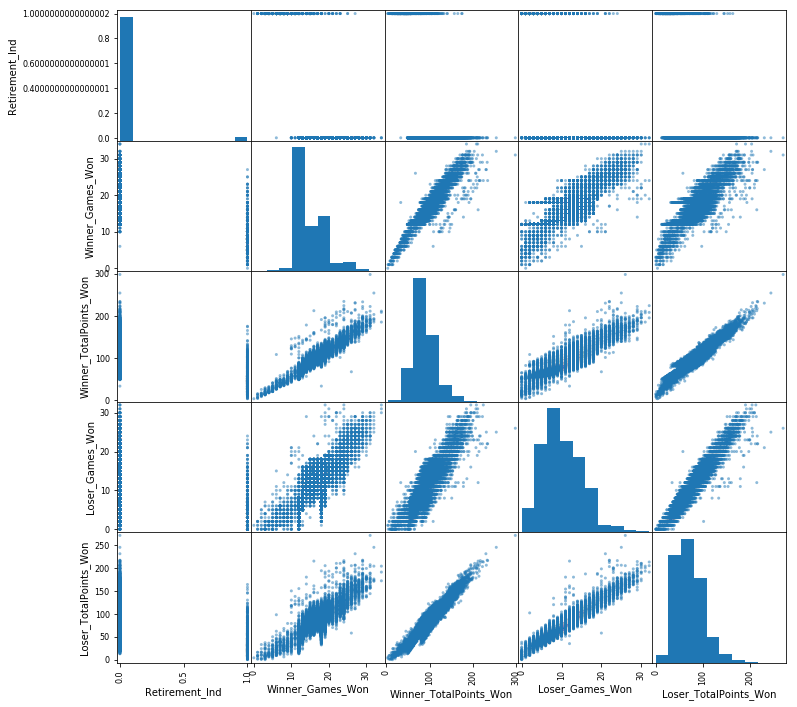

In [31]:
pd.scatter_matrix(df_atp, figsize=(12, 12))
plt.show()

In [30]:
# As we see the data is time series so it doesn't make much sense exploring now. So we clean and apply methods of 
# time series.

In [35]:
# Let do some exploration on the few important columns.
df_atp["Court_Surface"].unique()

array(['Hard', 'Indoor Hard', 'Clay', 'Grass'], dtype=object)

In [36]:
df_atp["Round_Description"].unique()

array(['First Round', 'Second Round', 'Quarter-finals', 'Semi-finals',
       'Finals', 'Qualifying', 'Third Round', 'Fourth Round', nan],
      dtype=object)

In [45]:
# As we see we dont need the qualifying round details; clay and grass court surafce is also not needed since 
# We are predicting for the hard and indoor hard surfaces. Let's remove them using the function _clean_data()
df_atp = DataProcessing._clean_data(df_atp)
df_wta = DataProcessing._clean_data(df_wta)

In [47]:
# Convert the data types of the data.
numeric_columns = ['Winner_Rank', 'Loser_Rank', 'Retirement_Ind','Winner_Sets_Won', 'Winner_Games_Won', 'Winner_Aces',
                   'Winner_DoubleFaults', 'Winner_FirstServes_Won','Winner_FirstServes_In', 'Winner_SecondServes_Won',
                   'Winner_SecondServes_In', 'Winner_BreakPoints_Won','Winner_BreakPoints', 'Winner_ReturnPoints_Won',
                   'Winner_ReturnPoints_Faced', 'Winner_TotalPoints_Won', 'Loser_Sets_Won','Loser_Games_Won', 
                   'Loser_Aces', 'Loser_DoubleFaults',
                   'Loser_FirstServes_Won', 'Loser_FirstServes_In','Loser_SecondServes_Won', 'Loser_SecondServes_In',
                   'Loser_BreakPoints_Won', 'Loser_BreakPoints', 'Loser_ReturnPoints_Won','Loser_ReturnPoints_Faced', 
                   'Loser_TotalPoints_Won']

date_columns = ['Tournament_Date']

df_atp = DataProcessing._change_datatype(df_atp)
df_wta = DataProcessing._change_datatype(df_wta)

In [49]:
# Tranform the data.
df_long_atp, df_long_wta = DataProcessing._transform_data(df_atp, df_wta)

In [50]:
df_long_atp.head()

,Player,Player_Rank,Player_Sets_Won,Player_Games_Won,Player_Aces,Player_DoubleFaults,Player_FirstServes_Won,Player_FirstServes_In,Player_SecondServes_Won,Player_SecondServes_In,...,Player_BreakPoints,Player_ReturnPoints_Won,Player_ReturnPoints_Faced,Player_TotalPoints_Won,Total_Games,Tournament,Tournament_Date,Court_Surface,Round_Description,won
0,Edouard Roger-Vasselin,106.0,2.0,12,5.0,2.0,22,30,12,19,...,7.0,25.0,59.0,59,19,Chennai,2012-01-02,Hard,First Round,1
1,Dudi Sela,83.0,2.0,12,2.0,0.0,14,17,11,16,...,14.0,36.0,58.0,61,13,Chennai,2012-01-02,Hard,First Round,1
2,Go Soeda,120.0,2.0,19,6.0,1.0,48,64,19,39,...,11.0,42.0,105.0,109,33,Chennai,2012-01-02,Hard,First Round,1
3,Yuki Bhambri,345.0,2.0,12,1.0,2.0,22,29,9,17,...,13.0,34.0,62.0,65,17,Chennai,2012-01-02,Hard,First Round,1
4,Yuichi Sugita,235.0,2.0,12,3.0,1.0,37,51,11,27,...,7.0,22.0,54.0,70,19,Chennai,2012-01-02,Hard,First Round,1


In [52]:
# Creating new features.
df_long_atp = DataProcessing._feature_engineering(df_long_atp)
df_long_wta = DataProcessing._feature_engineering(df_long_wta)

In [53]:
df_long_atp.head()

,Player,Player_Rank,Player_Sets_Won,Player_Games_Won,Player_Aces,Player_DoubleFaults,Player_FirstServes_Won,Player_FirstServes_In,Player_SecondServes_Won,Player_SecondServes_In,...,Total_Games,Tournament,Tournament_Date,Court_Surface,Round_Description,won,Player_Serve_Win_Ratio,Player_Return_Win_Ratio,Player_BreakPoints_Per_Return_Game,Player_Game_Win_Percentage
0,Edouard Roger-Vasselin,106.0,2.0,12,5.0,2.0,22,30,12,19,...,19,Chennai,2012-01-02,Hard,First Round,1,0.627451,0.423729,0.368421,0.631579
1,Dudi Sela,83.0,2.0,12,2.0,0.0,14,17,11,16,...,13,Chennai,2012-01-02,Hard,First Round,1,0.757576,0.620690,1.076923,0.923077
2,Go Soeda,120.0,2.0,19,6.0,1.0,48,64,19,39,...,33,Chennai,2012-01-02,Hard,First Round,1,0.634615,0.400000,0.333333,0.575758
3,Yuki Bhambri,345.0,2.0,12,1.0,2.0,22,29,9,17,...,17,Chennai,2012-01-02,Hard,First Round,1,0.604167,0.548387,0.764706,0.705882
4,Yuichi Sugita,235.0,2.0,12,3.0,1.0,37,51,11,27,...,19,Chennai,2012-01-02,Hard,First Round,1,0.594937,0.407407,0.368421,0.631579


In [54]:
df_long_atp["Tournament"].unique()

array(['Chennai', 'Brisbane', 'Doha', 'Sydney', 'Auckland',
       'Australian Open, Melbourne', 'Montpellier', 'Zagreb', 'Rotterdam',
       'San Jose', 'Marseille', 'Memphis', 'Delray Beach', 'Dubai',
       'Indian Wells', 'Miami', 'Atlanta', 'Los Angeles', 'Washington',
       'Toronto', 'Cincinnati', 'Winston-Salem', 'U.S. Open, New York',
       'Metz', 'St. Petersburg', 'Kuala Lumpur', 'Bangkok', 'Beijing',
       'Tokyo', 'Shanghai', 'Vienna', 'Stockholm', 'Moscow', 'Basel',
       'Valencia', 'Paris', 'London', 'Bogota', 'Montreal', 'Acapulco',
       'Shenzhen', 'Sofia', 'Los Cabos', 'Rio de Janeiro', 'Chengdu',
       'Antwerp', 'Milan', 'Pune', 'New York'], dtype=object)

In [67]:
# We will use only the follwing tournaments.
tournaments = ['U.S. Open, New York','Australian Open, Melbourne']

tournament_dates_atp, tournament_dates_wta = DataProcessing._create_tournament_data()

In [74]:
# columns we are applying the rolling averages on
rolling_cols = ['Player_Serve_Win_Ratio', 'Player_Return_Win_Ratio',
               'Player_BreakPoints_Per_Return_Game', 'Player_Game_Win_Percentage']

# columns we are taking the most recent values on
# For the player rank, we think we can just use the latest rank (before the tournament starts) 
# as it should refect the most recent performance of the player
last_cols = ['Player_Rank']

# Apply the rolling average function to the long dataframes (it will take a few mins to run)
df_rolling_atp = DataProcessing._calculate_rolling_averages(df_long_atp, tournament_dates_atp, rolling_cols, last_cols= last_cols)
df_rolling_wta = DataProcessing._calculate_rolling_averages(df_long_wta, tournament_dates_wta, rolling_cols, last_cols= last_cols)

In [86]:
df_rolling_atp.head()

,Player,Player_Serve_Win_Ratio,Player_Return_Win_Ratio,Player_BreakPoints_Per_Return_Game,Player_Game_Win_Percentage,Player_Rank,tournament_date_index
0,Adrian Mannarino,0.623408,0.353397,0.257859,0.447246,87.0,2012-01-16
1,Albert Montanes,0.507246,0.195652,0.000000,0.294118,50.0,2012-01-16
2,Albert Ramos-Vinolas,0.498027,0.380092,0.414815,0.394444,65.0,2012-01-16
3,Alejandro Falla,0.527654,0.435505,0.338679,0.497891,80.0,2012-01-16
4,Alex Bogomolov Jr.,0.553281,0.399178,0.385507,0.486675,34.0,2012-01-16


In [76]:
df_rolling_atp.shape

(5422, 7)

In [78]:
len(df_rolling_atp["Player"].unique())

510

In [83]:
#df_rolling_atp[df_rolling_atp["Player"] == "Adrian Mannarino"]

In [89]:
# Let's randomise the data.
DataProcessing._randomise_data()

After shuffling, the win rate for player 1 for the mens is 49.64798919857267%
After shuffling, the win rate for player 1 for the womens is 49.697671426733564%


In [94]:
df_atp, df_wta = DataProcessing._merge_data(df_atp, df_wta)

In [95]:
df_atp.head()

,Winner,Loser,Tournament,Tournament_Date,player_1_win,randomised_player_1,randomised_player_2,Player_p1,Player_Serve_Win_Ratio_p1,Player_Return_Win_Ratio_p1,...,Player_Game_Win_Percentage_p1,Player_Rank_p1,tournament_date_index_p1,Player_p2,Player_Serve_Win_Ratio_p2,Player_Return_Win_Ratio_p2,Player_BreakPoints_Per_Return_Game_p2,Player_Game_Win_Percentage_p2,Player_Rank_p2,tournament_date_index_p2
0,Juan Martin del Potro,Adrian Mannarino,"Australian Open, Melbourne",2012-01-16,1,Juan Martin del Potro,Adrian Mannarino,Juan Martin del Potro,0.658439,0.332126,...,0.550725,11.0,2012-01-16,Adrian Mannarino,0.623408,0.353397,0.257859,0.447246,87.0,2012-01-16
1,Pere Riba,Albert Montanes,"Australian Open, Melbourne",2012-01-16,1,Pere Riba,Albert Montanes,Pere Riba,0.350877,0.204545,...,0.200000,89.0,2012-01-16,Albert Montanes,0.507246,0.195652,0.000000,0.294118,50.0,2012-01-16
2,Tomas Berdych,Albert Ramos-Vinolas,"Australian Open, Melbourne",2012-01-16,0,Albert Ramos-Vinolas,Tomas Berdych,Albert Ramos-Vinolas,0.498027,0.380092,...,0.394444,65.0,2012-01-16,NaN,NaN,NaN,NaN,NaN,NaN,NaT
3,Rafael Nadal,Alex Kuznetsov,"Australian Open, Melbourne",2012-01-16,0,Alex Kuznetsov,Rafael Nadal,NaN,NaN,NaN,...,NaN,NaN,NaT,Rafael Nadal,0.670139,0.423057,0.445623,0.574767,2.0,2012-01-16
4,Roger Federer,Alexander Kudryavtsev,"Australian Open, Melbourne",2012-01-16,0,Alexander Kudryavtsev,Roger Federer,NaN,NaN,NaN,...,NaN,NaN,NaT,Roger Federer,0.721415,0.449516,0.360255,0.668090,3.0,2012-01-16


In [96]:
# How many players do not have previous match history
print('{} player_1s do Not have previous match history before the tournament'.format(df_atp.loc[df_atp.Player_p1.isna(),'randomised_player_1'].nunique()))
print('{} player_2s do Not have previous match history before the tournament'.format(df_atp.loc[df_atp.Player_p2.isna(),'randomised_player_2'].nunique()))

59 player_1s do Not have previous match history before the tournament
56 player_2s do Not have previous match history before the tournament


In [97]:
# How many players do not have previous match history
print('{} player_1s do Not have previous match history before the tournament'.format(df_wta.loc[df_wta.Player_p1.isna(),'randomised_player_1'].nunique()))
print('{} player_2s do Not have previous match history before the tournament'.format(df_wta.loc[df_wta.Player_p2.isna(),'randomised_player_2'].nunique()))

41 player_1s do Not have previous match history before the tournament
37 player_2s do Not have previous match history before the tournament


In [98]:
# Most of the missing are for the early years which makes sense as we dont have enough history for them
df_wta.loc[df_wta.Player_p1.isna(),'Tournament_Date'].value_counts()

2014-01-13    29
2014-08-25     7
2015-08-31     5
2015-01-19     3
2017-08-28     3
2018-01-15     3
2018-08-27     3
Name: Tournament_Date, dtype: int64

In [99]:
df_atp.loc[df_atp.Player_p1.isna(),'Tournament_Date'].value_counts()

2012-01-16    29
2012-08-27     9
2014-01-13     5
2013-08-26     5
2016-01-18     5
2013-01-14     4
2014-08-25     3
2018-01-15     3
2017-08-28     3
2018-08-27     2
2016-08-29     2
2015-01-19     1
Name: Tournament_Date, dtype: int64

In [102]:
diff_cols = ['Player_Serve_Win_Ratio',
            'Player_Return_Win_Ratio',
            'Player_BreakPoints_Per_Return_Game',
            'Player_Game_Win_Percentage','Player_Rank']

# Apply the function and get the difference between player 1 and 2.
df_atp,_ = DataProcessing._calculate_player_diff(df_atp,diff_cols=diff_cols)
df_wta,_ = DataProcessing._calculate_player_diff(df_wta,diff_cols=diff_cols)

# Make a copy of the dataframes.
df_atp_final = df_atp.copy()
df_wta_final = df_wta.copy()

In [103]:
df_atp_final.head()

,Winner,Loser,Tournament,Tournament_Date,player_1_win,randomised_player_1,randomised_player_2,Player_p1,tournament_date_index_p1,Player_p2,tournament_date_index_p2,Player_Serve_Win_Ratio_diff,Player_Return_Win_Ratio_diff,Player_BreakPoints_Per_Return_Game_diff,Player_Game_Win_Percentage_diff,Player_Rank_diff
0,Juan Martin del Potro,Adrian Mannarino,"Australian Open, Melbourne",2012-01-16,1,Juan Martin del Potro,Adrian Mannarino,Juan Martin del Potro,2012-01-16,Adrian Mannarino,2012-01-16,0.035030,-0.021271,-0.025975,0.103479,-76.0
1,Pere Riba,Albert Montanes,"Australian Open, Melbourne",2012-01-16,1,Pere Riba,Albert Montanes,Pere Riba,2012-01-16,Albert Montanes,2012-01-16,-0.156369,0.008893,0.066667,-0.094118,39.0
2,Tomas Berdych,Albert Ramos-Vinolas,"Australian Open, Melbourne",2012-01-16,0,Albert Ramos-Vinolas,Tomas Berdych,Albert Ramos-Vinolas,2012-01-16,NaN,NaT,0.498027,0.380092,0.414815,0.394444,-934.0
3,Rafael Nadal,Alex Kuznetsov,"Australian Open, Melbourne",2012-01-16,0,Alex Kuznetsov,Rafael Nadal,NaN,NaT,Rafael Nadal,2012-01-16,-0.670139,-0.423057,-0.445623,-0.574767,997.0
4,Roger Federer,Alexander Kudryavtsev,"Australian Open, Melbourne",2012-01-16,0,Alexander Kudryavtsev,Roger Federer,NaN,NaT,Roger Federer,2012-01-16,-0.721415,-0.449516,-0.360255,-0.668090,996.0


In [104]:
df_train_atp = df_atp_final.loc[(df_atp_final.Tournament_Date != '2018-01-15') # excluding Aus Open 2018, and
                                & (df_atp_final.Tournament_Date > '2012-01-16')] # excluding first year
df_valid_atp = df_atp_final.loc[df_atp_final.Tournament_Date == '2018-01-15'] # Australian Open 2018 only

df_train_wta = df_wta_final.loc[(df_wta_final.Tournament_Date != '2018-01-15') # excluding Aus Open 2018, and
                                & (df_wta_final.Tournament_Date > '2014-01-13')] # excluding first year


In [105]:
# target variable
target= 'player_1_win'

# features being fed into the models
feats = ['Player_Serve_Win_Ratio_diff',
         'Player_Return_Win_Ratio_diff',
         'Player_BreakPoints_Per_Return_Game_diff',
         'Player_Game_Win_Percentage_diff',
         'Player_Rank_diff']

print(feats)

['Player_Serve_Win_Ratio_diff', 'Player_Return_Win_Ratio_diff', 'Player_BreakPoints_Per_Return_Game_diff', 'Player_Game_Win_Percentage_diff', 'Player_Rank_diff']


In [106]:
df_train_atp.head()

,Winner,Loser,Tournament,Tournament_Date,player_1_win,randomised_player_1,randomised_player_2,Player_p1,tournament_date_index_p1,Player_p2,tournament_date_index_p2,Player_Serve_Win_Ratio_diff,Player_Return_Win_Ratio_diff,Player_BreakPoints_Per_Return_Game_diff,Player_Game_Win_Percentage_diff,Player_Rank_diff
126,Daniel Brands,Adrian Ungur,"U.S. Open, New York",2012-08-27,0,Adrian Ungur,Daniel Brands,NaN,NaT,Daniel Brands,2012-08-27,-0.535211,-0.300000,-0.043478,-0.434783,870.0
127,Richard Gasquet,Albert Montanes,"U.S. Open, New York",2012-08-27,1,Richard Gasquet,Albert Montanes,Richard Gasquet,2012-08-27,Albert Montanes,2012-08-27,0.080003,0.077451,0.180847,0.131108,-37.0
128,Martin Klizan,Alejandro Falla,"U.S. Open, New York",2012-08-27,1,Martin Klizan,Alejandro Falla,Martin Klizan,2012-08-27,Alejandro Falla,2012-08-27,0.077117,-0.044716,-0.087362,0.068180,-2.0
129,Andy Murray,Alex Bogomolov Jr.,"U.S. Open, New York",2012-08-27,1,Andy Murray,Alex Bogomolov Jr.,Andy Murray,2012-08-27,Alex Bogomolov Jr.,2012-08-27,0.039641,0.031701,0.094722,0.059010,-69.0
130,Tommy Robredo,Andreas Seppi,"U.S. Open, New York",2012-08-27,1,Tommy Robredo,Andreas Seppi,Tommy Robredo,2012-08-27,Andreas Seppi,2012-08-27,-0.026814,0.006442,-0.009930,-0.067780,151.0


In [107]:
df_valid_atp.head()

,Winner,Loser,Tournament,Tournament_Date,player_1_win,randomised_player_1,randomised_player_2,Player_p1,tournament_date_index_p1,Player_p2,tournament_date_index_p2,Player_Serve_Win_Ratio_diff,Player_Return_Win_Ratio_diff,Player_BreakPoints_Per_Return_Game_diff,Player_Game_Win_Percentage_diff,Player_Rank_diff
1518,Viktor Troicki,Alex Bolt,"Australian Open, Melbourne",2018-01-15,0,Alex Bolt,Viktor Troicki,Alex Bolt,2018-01-15,Viktor Troicki,2018-01-15,-0.051311,-0.022544,0.028941,-0.061211,135.0
1519,Tomas Berdych,Alex de Minaur,"Australian Open, Melbourne",2018-01-15,0,Alex de Minaur,Tomas Berdych,Alex de Minaur,2018-01-15,Tomas Berdych,2018-01-15,0.013382,-0.001403,0.041982,-0.031041,148.0
1520,Tim Smyczek,Alexei Popyrin,"Australian Open, Melbourne",2018-01-15,0,Alexei Popyrin,Tim Smyczek,Alexei Popyrin,2018-01-15,Tim Smyczek,2018-01-15,-0.148025,-0.102477,-0.189637,-0.093299,864.0
1521,Roger Federer,Aljaz Bedene,"Australian Open, Melbourne",2018-01-15,0,Aljaz Bedene,Roger Federer,Aljaz Bedene,2018-01-15,Roger Federer,2018-01-15,-0.121506,-0.057214,-0.102183,-0.184331,49.0
1522,Alexandr Dolgopolov,Andreas Haider-Maurer,"Australian Open, Melbourne",2018-01-15,0,Andreas Haider-Maurer,Alexandr Dolgopolov,Andreas Haider-Maurer,2018-01-15,Alexandr Dolgopolov,2018-01-15,-0.093544,-0.079319,-0.015372,-0.095563,414.0


In [119]:
aml_atp, lb = Model._build_h2o(df_train_atp, df_valid_atp, feats)

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_141"; Java(TM) SE Runtime Environment (build 1.8.0_141-b15); Java HotSpot(TM) 64-Bit Server VM (build 25.141-b15, mixed mode)
  Starting server from /anaconda/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/cl/qrkq25zj1hd_3q30h5vyfmlh0000gn/T/tmpwxh1g19d
  JVM stdout: /var/folders/cl/qrkq25zj1hd_3q30h5vyfmlh0000gn/T/tmpwxh1g19d/h2o_sandeepkola_started_from_python.out
  JVM stderr: /var/folders/cl/qrkq25zj1hd_3q30h5vyfmlh0000gn/T/tmpwxh1g19d/h2o_sandeepkola_started_from_python.err
  Server is running at http://127.0.0.1:54323
Connecting to H2O server at http://127.0.0.1:54323... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,Australia/Melbourne
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.1.1
H2O cluster version age:,1 month and 15 days
H2O cluster name:,H2O_from_python_sandeepkola_3dcyn8
H2O cluster total nodes:,1
H2O cluster free memory:,3.556 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%


In [120]:
lb.head()

model_id,auc,logloss,mean_per_class_error,rmse,mse
GBM_5_AutoML_20190213_130850,0.790281,0.554852,0.281363,0.431379,0.186088
GBM_grid_1_AutoML_20190213_130850_model_20,0.789329,0.556804,0.29856,0.431931,0.186564
XGBoost_grid_1_AutoML_20190213_130850_model_3,0.789111,0.557319,0.277369,0.432574,0.187121
GBM_grid_1_AutoML_20190213_130850_model_12,0.788013,0.557808,0.295899,0.432968,0.187461
StackedEnsemble_BestOfFamily_AutoML_20190213_130850,0.785233,0.560316,0.284004,0.434004,0.188359
XGBoost_3_AutoML_20190213_130850,0.78596,0.560817,0.304508,0.434176,0.188509
XGBoost_grid_1_AutoML_20190213_130850_model_5,0.784618,0.560892,0.28663,0.434215,0.188542
StackedEnsemble_AllModels_AutoML_20190213_130850,0.785,0.560971,0.2946,0.434187,0.188519
XGBoost_grid_1_AutoML_20190213_130850_model_6,0.78218,0.562719,0.295213,0.43513,0.189338
XGBoost_grid_1_AutoML_20190213_130850_model_1,0.78819,0.563858,0.28865,0.434822,0.18907
